# Project Title
### Data Engineering Capstone Project

#### Project Summary
At my current job I haven't been cleared to look into AWS tools as used in this course, so I'm keeping functionality as originally outlined in the project by only utilizing Spark in this notebook.

The rest of the pipeline is done through this notebook, using SQL and Python wrappers. I'm trying to maintain best practices around steps that could be run in parallel if this were to be moved to Airflow, for example, but my main focus is on proving my ability to take in a file, clean it, and transform it into something usable based on tools at my current disposal.

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [10]:
# Do all imports and installs here
import pandas as pd, re
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf

### Step 1: Scope the Project and Gather Data

#### Scope 
The end result of this project will to provide a database built from a data pipeline. This database will house data for business users to access and explore possible correlations between World Temperature metrics and various U.S. City Demographics.

#### Describe and Gather Data 
This capstone is done with the Udacity-provided project - of the four datasets provided, I'll be using: 
* I94 Immigration Data: This data comes from the US National Tourism and Trade Office.
* World Temperature Data: This dataset came from Kaggle.

In [2]:
# Read in the data here
imm_fname = '../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat'
imm_df = pd.read_sas(imm_fname, 'sas7bdat', encoding="ISO-8859-1")

In [3]:
imm_df.head()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,6.0,2016.0,4.0,692.0,692.0,XXX,20573.0,NaN,NaN,NaN,...,U,NaN,1979.0,10282016,NaN,NaN,NaN,1.897628e+09,NaN,B2
1,7.0,2016.0,4.0,254.0,276.0,ATL,20551.0,1.0,AL,NaN,...,Y,NaN,1991.0,D/S,M,NaN,NaN,3.736796e+09,00296,F1
2,15.0,2016.0,4.0,101.0,101.0,WAS,20545.0,1.0,MI,20691.0,...,NaN,M,1961.0,09302016,M,NaN,OS,6.666432e+08,93,B2
3,16.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,NaN,M,1988.0,09302016,NaN,NaN,AA,9.246846e+10,00199,B2
4,17.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,NaN,M,2012.0,09302016,NaN,NaN,AA,9.246846e+10,00199,B2


In [4]:
spark = SparkSession.builder.\
config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11")\
.enableHiveSupport().getOrCreate()
df_spark =spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')


In [7]:
temp_fname = '../../data2/GlobalLandTemperaturesByCity.csv'
temp_df = pd.read_csv(temp_fname)

In [8]:
temp_df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


### Step 2: Explore and Assess the Data
#### Exploring & Cleaning the Data
Immigration data - Need to remove intances where the destination city code i94port is not a valid value; this seems to appear in values like XXX & NaN.

Temperature Data - Need to remove instances where AverageTemperature is NaN. Also need to check for duplicate locations and remove if they exist (they do).

In [98]:
# Performing cleaning tasks here
# List of valid i94port found online from various sources, no one place to attribute to
re_obj = re.compile(r'\'(.*)\'.*\'(.*)\'')
i94port = {}
with open('i94port.txt') as f:
     for line in f:
         match = re_obj.search(line)
         i94port[match[1]]=[match[2]]

In [99]:
def clean_data(file):
    '''    
    Input: immigration file
    Output: Spark with valid i94port values
    '''    
    # get data into Spark and get rid of invalid values
    df_imm = spark.read.format('com.github.saurfang.sas.spark').load(file)

    # Filter out entries where i94port is invalid
    df_imm = df_imm.filter(df_imm.i94port.isin(list(i94port.keys())))
    return df_imm

In [52]:
temp = spark.read.format("csv").option("header", "true").load("../../data2/GlobalLandTemperaturesByCity.csv")
temp = temp.filter(temp.AverageTemperature != 'NaN')
temp = temp.dropDuplicates(['City', 'Country'])

@udf()
def addin_i94(ci):
    '''
    Input: city name
    Output: its i94port code
    '''
    for key in i94port:
        if ci.lower() in i94port[key][0].lower():
            return key
# add that value
temp = temp.withColumn("i94portcode", addin_i94(temp.City))
temp.head()

Row(dt='1743-11-01', AverageTemperature='3.264', AverageTemperatureUncertainty='1.665', City='Allentown', Country='United States', Latitude='40.99N', Longitude='74.56W', i94portcode=None)

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model & 3.2 Mapping Out Data Pipelines
These seem to correlate to how others have viewed, discussed, and decided to use these two specific data sets based on the community chat and similar resources. Will continue on as outlined below.

The fact table:

* arrdate = (Imm file)
* depdate = (from Imm file)
* AverageTemperature = temp data by city (from Temp file)
* i94cit = origin city code (from Imm file)
* temp_city = city (from Temp file)
* i94mode = provided travel 'code' (Imm file)
* i94mon = month (Imm file)
* i94port = dest city (cleaned up to be relevant in prior step - Imm file)
* i94visa = purpose/reason (from Imm file)
* i94yr = year (Imm file)

A dimension table comes from Immigration - see above for more details on data

* arrdate
* depdate
* i94cit
* i94mode
* i94mon
* i94port
* i94visa
* i94yr

Another dimension table originated from Temperature:

* AverageTemperature
* City
* Country
* Latitude
* Longitude
* i94port

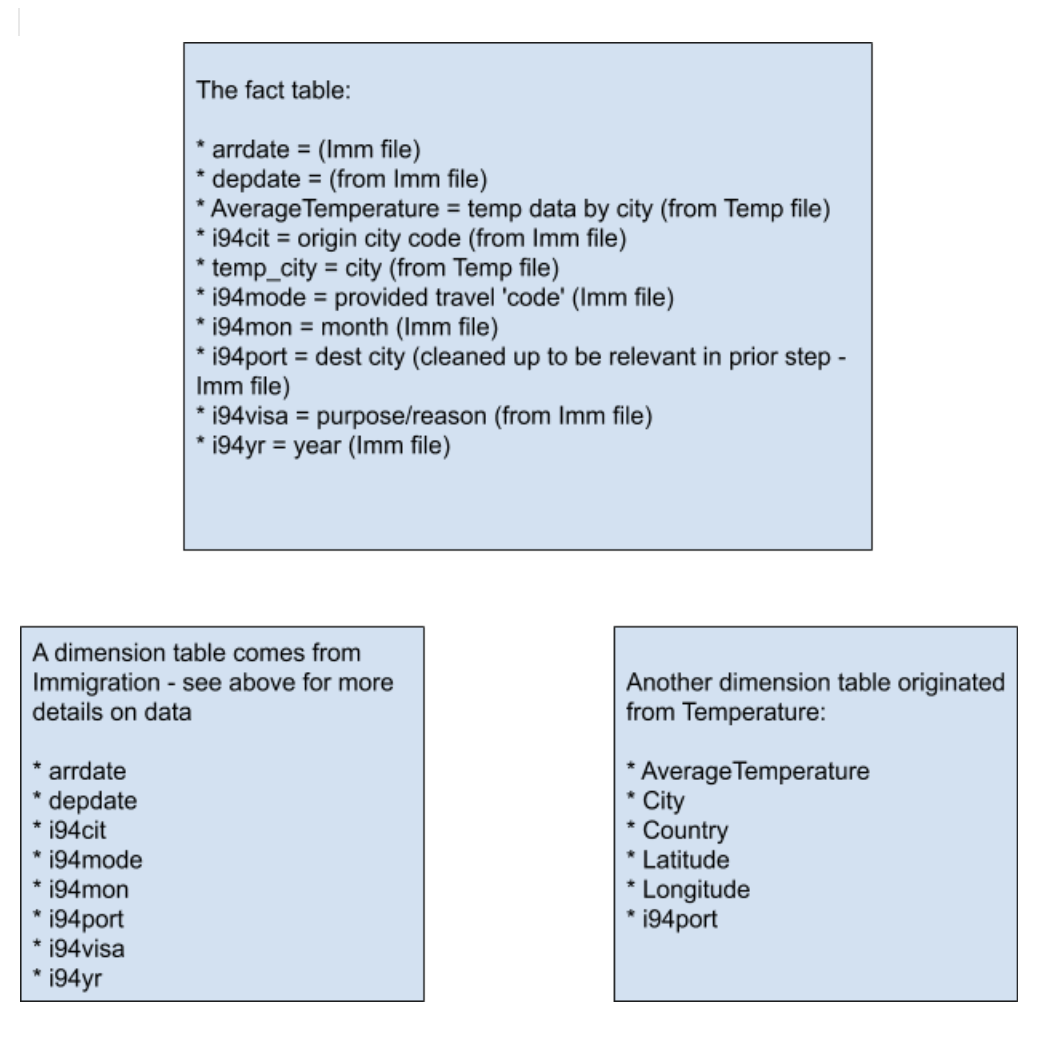

In [97]:
from IPython.display import Image 

Image("schema.png")

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Will focus on the columns as outlined in the above step.

In [58]:
# Write code here
# grab and clean data - reference Step 2, above
imm_data = '/data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat'
immigration = clean_data(imm_data)
immigration.head()
# # only grab relevant columns
imm_table = immigration.select(["arrdate", "depdate", "i94cit", "i94yr", "i94mode", "i94mon", "i94port", "i94visa"])
# using append (large tables) partition by that same i94port code
imm_table.write.mode("append").partitionBy("i94port").parquet("/results/immigration.parquet")
imm_table.head()

Row(arrdate=20551.0, depdate=None, i94cit=254.0, i94yr=2016.0, i94mode=1.0, i94mon=4.0, i94port='ATL', i94visa=3.0)

In [57]:
temp_table = temp.select(["AverageTemperature", "City", "Country", "Latitude", "Longitude", "i94portcode"])
# using append (large tables) partition by that same i94port code
temp_table.write.mode("append").partitionBy("i94portcode").parquet("/results/temperature.parquet")
temp_table.head()

Row(AverageTemperature='3.264', City='Allentown', Country='United States', Latitude='40.99N', Longitude='74.56W', i94portcode=None)

In [68]:
# # use sql script to build out our fact table, bringing in both temp and imm data
# fact_table = spark.sql('''
#                         SELECT imm_table.arrdate as arrival_date,
#                             imm_table.depdate as departure_date,
#                             temp_table.AverageTemperature as temperature,
#                             imm_table.i94cit as city,
#                             imm_table.i94mon as month,
#                             imm_table.i94mode as travel_code,
#                             imm_table.i94port as i94port,
#                             imm_table.i94visa as reason,   
#                             imm_table.i94yr as year
#                         FROM imm_table
#                         JOIN temp_table ON (imm_table.i94port = temp_table.i94portcode)
#                         ''')
# # using append (large tables) partition by that same i94port code
# fact_table.write.mode("append").partitionBy("i94port").parquet("/results/fact.parquet")

In [70]:
# spark.sql doesn't work when using the imm and temp tables straight up - found workaround to use 'views' instead
imm_table.createOrReplaceTempView("imm_view")
temp_table.createOrReplaceTempView("temp_view")

fact_table = spark.sql('''
                        SELECT imm_view.arrdate as arrival_date,
                            imm_view.depdate as departure_date,
                            temp_view.AverageTemperature as temperature,
                            imm_view.i94cit as city,
                            temp_view.City as temp_city,
                            imm_view.i94mon as month,
                            imm_view.i94mode as travel_code,
                            imm_view.i94port as i94port,
                            imm_view.i94visa as reason,   
                            INT(imm_view.i94yr) as year
                        FROM imm_view
                        JOIN temp_view ON (imm_view.i94port = temp_view.i94portcode)
                        ''')
# using append (large tables) partition by that same i94port code (same as prior tables)
fact_table.write.mode("append").partitionBy("i94port").parquet("/results/fact.parquet")

In [72]:
fact_table.head()

Row(arrival_date=20545.0, departure_date=20547.0, temperature='7.168999999999999', city=111.0, temp_city='San Antonio', month=4.0, travel_code=1.0, i94port='SNA', reason=1.0, year=2016)

#### 4.2 Data Quality Checks
 
* For this data, I will do a row # compare against my cleaned data and the end dimension tables to ensure nothing was lost in the tempporary view/transform stage
 
Run Quality Checks

In [88]:
# Perform quality checks here
def quality_check_imm(df, description):
    '''
    Input: what we're looking at (each table)
    Output: result of check
    '''
    result = df.count()
    imm_count = immigration.count()
    if result == imm_count:
        print("Data check passed for {}; {} rows tie between various stages of data".format(description, result))     
    else:
        print("Data check failed for {} - does not tie with cleaned data table".format(description)) 
    return

In [89]:
quality_check_imm(imm_table, "imm_table")

Data check passed for imm_table - 3088544 number of rows tie between various stages of data


In [90]:
def quality_check_temp(df, description):
    '''
    Input: what we're looking at (each table)
    Output: result of check
    '''
    result = df.count()
    temp_count = temp.count()
    if result == temp_count:
        print("Data check passed for {}; {} rows tie between various stages of data".format(description, result))
    else:
        print("Data check failed for {} - does not tie with cleaned data table".format(description))
    return

In [91]:
quality_check_temp(temp_table, "temp_table")

Data check passed for temp_table - 3490 number of rows tie between various stages of data


#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

I did include a file as my main dictionary (outside of the general definitions I provided when outlining the fact and dimension tables) - file 194port.txt. Fields that are not explicitly described when outlining the tables are obvious in nature, such as latitude and longitude.



#### Step 5: Complete Project Write Up

 ### Clearly state the rationale for the choice of tools and technologies for the project.
 
 The rationale of my choices is outlined at the beginning of the project - namely, how can I prove my understanding of an ETL process by utilizing the Udacity community and minimizing AWS tools? The program has been a great introduction to tools available to a data engineer, but since I'll be starting 'scrappy' at my current postition I wanted to leverage what I could of affordable tools, like Jupyter Notebook.
 
 By initially exploring the data, then using Spark to both clean and transform, and load that data into new tables, I was able to stretch my legs while keeping in the back of my mind how I would be able to utilize Airflow to better illustrate and control pipelines when budgets allow.
 
 ### Propose how often the data should be updated and why.
 
 The two data sets I've chosen, World Temp and Immigration, both hold enough historical data for end users to explore. The nature of this data is not one that would require an hourly, or even weekly update - no new insights would be gleaned from more frequent refreshes. To me, a monthly or even quarterly update would more than suffice; in most cases, reliable data around world temps and immigration would only be published for use on a monthly or quarterly cadence, rendering more frequent updates irrelevent.
 
 
 ### Write a description of how you would approach the problem differently under the following scenarios:
 
 #### The data was increased by 100x.
 
 By increased, I picture the freqency of new data - in which case, there would be a strong argument to initiate something like Airflow to establish DAGs that could run on a schedule, with errors and alerts sent out as needed.
 
 If instead, increased meant the sheer volume of data, I would build Spark into utilizing Redshift and scale up as needed, bypassing Jupyter except as a prototype tool.
 
 #### The data populates a dashboard that must be updated on a daily basis by 7am every day.
 
 Again, if frequency where impacted I would rely on Airflow to monitor if my pipeline broke, since I have end users looking for updated, visualized data first thing each morning. Since things would also need to run smoother and with no manual hand-holding, I would make the case that spinning up Redshift would be beneficial.
 
 #### The database needed to be accessed by 100+ people.
 
 Gaining the most common user requirements and loading the end results into an easily-accessible, quick loading OLAP cube for that many users seems like a tie back to what we learned earlier in the program, and like a great use-case for this instance.
 
 Along with that, to build trust and more frequent checks and working with some of those users to gain an agreement of what each step of the way seems like how a good data engineer would approach this need.